<a href="https://colab.research.google.com/github/sheershaagrawal/projectdatamites/blob/master/PRCP_1004_Fifa20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload and Extract FIFA 20 Dataset (ZIP File)

In [ ]:
import zipfile
import os

# Automatically find the zip file
zip_file = [f for f in os.listdir('/content') if f.endswith('.zip')][0]
print("ZIP FILE FOUND:", zip_file)

# Create extraction folder
extract_folder = "fifa_data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extracted files:", os.listdir(extract_folder))


ZIP FILE FOUND: PRCP-1004-Fifa20.zip
Extracted files: ['Data']


In [ ]:
import pandas as pd

# Find CSV automatically
csv_path = ""
for root, dirs, files in os.walk("fifa_data"):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)

print("CSV FOUND AT:", csv_path)

df = pd.read_csv(csv_path)
df.head()


CSV FOUND AT: fifa_data/Data/players_20.csv


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


Locate and Load Dataset

In [ ]:
df.shape


(18278, 104)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Columns: 104 entries, sofifa_id to rb
dtypes: float64(16), int64(45), object(43)
memory usage: 14.5+ MB


In [ ]:
df.drop_duplicates(inplace=True)

num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [ ]:
forward_positions = ['ST','RS','LS','CF','RF','LF','RW','LW']
df = df[df['player_positions'].str.contains('|'.join(forward_positions), na=False)]


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['preferred_foot'] = le.fit_transform(df['preferred_foot'])


In [ ]:
features = [
    'age','height_cm','preferred_foot','weak_foot',
    'pace','shooting','passing','dribbling','defending','physic'
]

X = df[features]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


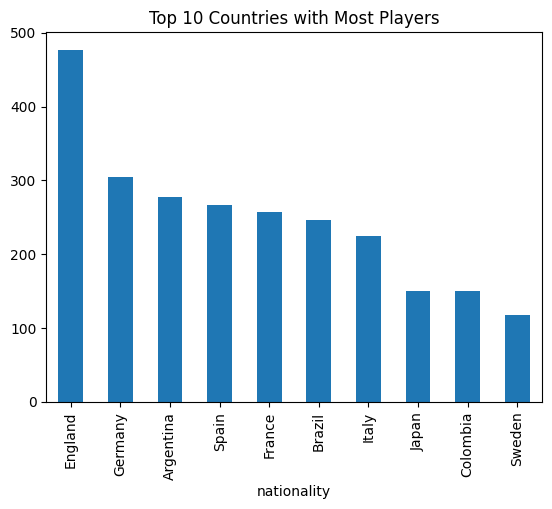

In [ ]:
import matplotlib.pyplot as plt

top_countries = df['nationality'].value_counts().head(10)
top_countries.plot(kind='bar')
plt.title("Top 10 Countries with Most Players")
plt.show()


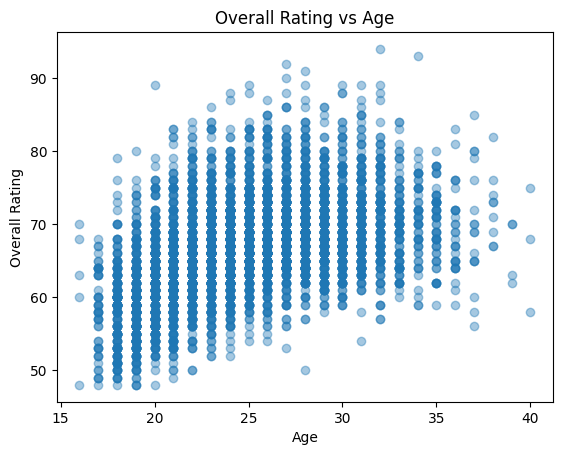

In [ ]:
plt.scatter(df['age'], df['overall'], alpha=0.4)
plt.xlabel("Age")
plt.ylabel("Overall Rating")
plt.title("Overall Rating vs Age")
plt.show()


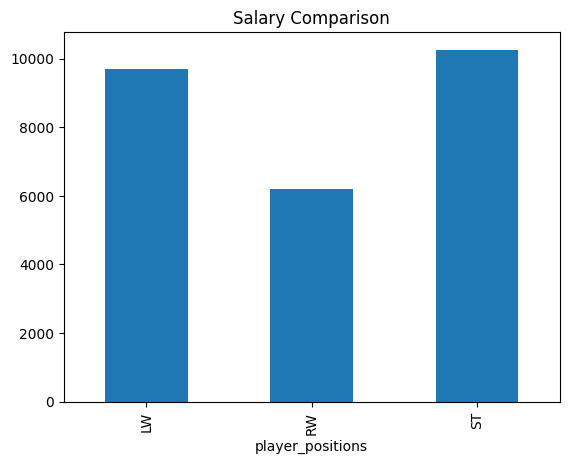

In [ ]:
salary_df = df[df['player_positions'].isin(['ST','RW','LW'])]

salary_df.groupby('player_positions')['wage_eur'].mean().plot(kind='bar')
plt.title("Salary Comparison")
plt.show()


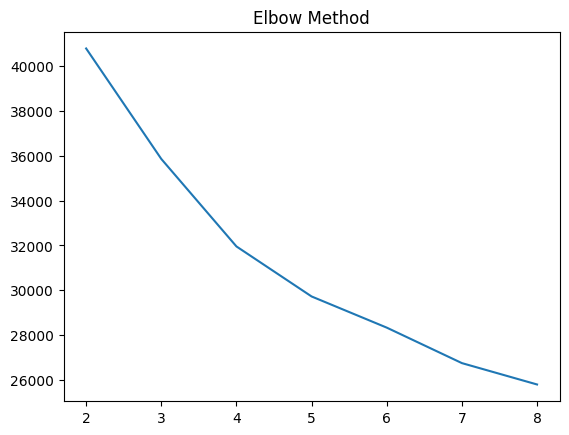

In [ ]:
from sklearn.cluster import KMeans

wcss = []
for k in range(2,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.plot(range(2,9), wcss)
plt.title("Elbow Method")
plt.show()


In [ ]:

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


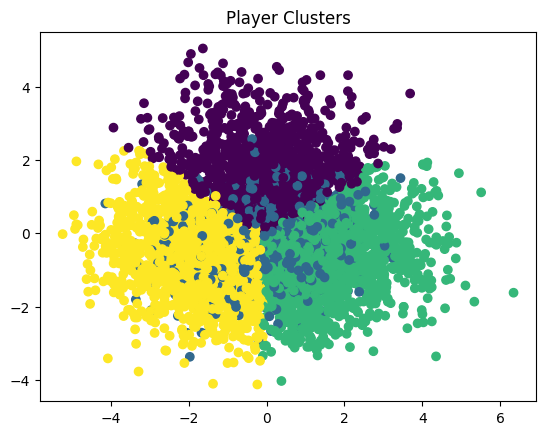

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

plt.scatter(pca_data[:,0], pca_data[:,1], c=df['Cluster'])
plt.title("Player Clusters")
plt.show()


Dimensionality Reduction using PCA

In [ ]:
df.groupby('Cluster')[features].mean()


,age,height_cm,preferred_foot,weak_foot,pace,shooting,passing,dribbling,defending,physic
Cluster,,,,,,,,,,
0,27.852354,186.293695,0.849162,3.140463,64.458899,66.778132,54.505188,63.992019,33.667199,71.280128
1,25.626277,178.740146,0.471533,2.807299,74.255474,49.129927,59.576642,65.021898,60.467153,66.678832
2,26.288875,176.897357,0.770744,3.418562,79.047326,68.571604,65.633682,74.174554,37.578980,62.925015
3,21.079439,178.817089,0.832443,2.894526,71.253672,56.955274,48.684246,60.977303,27.036048,54.241656
